<a href="https://colab.research.google.com/github/siwookim1114/Data-Science-Projects/blob/main/Netflix_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Stock Price Prediction

## Import Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## Read Data

In [2]:
file_path = "/content/drive/MyDrive/ML AI/Data Science Projects/Data/NFLX.csv"
df = pd.read_csv(file_path)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


### Column Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


## Data Preprocessing

### Check for Null Values

In [5]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


### Check for Outliers

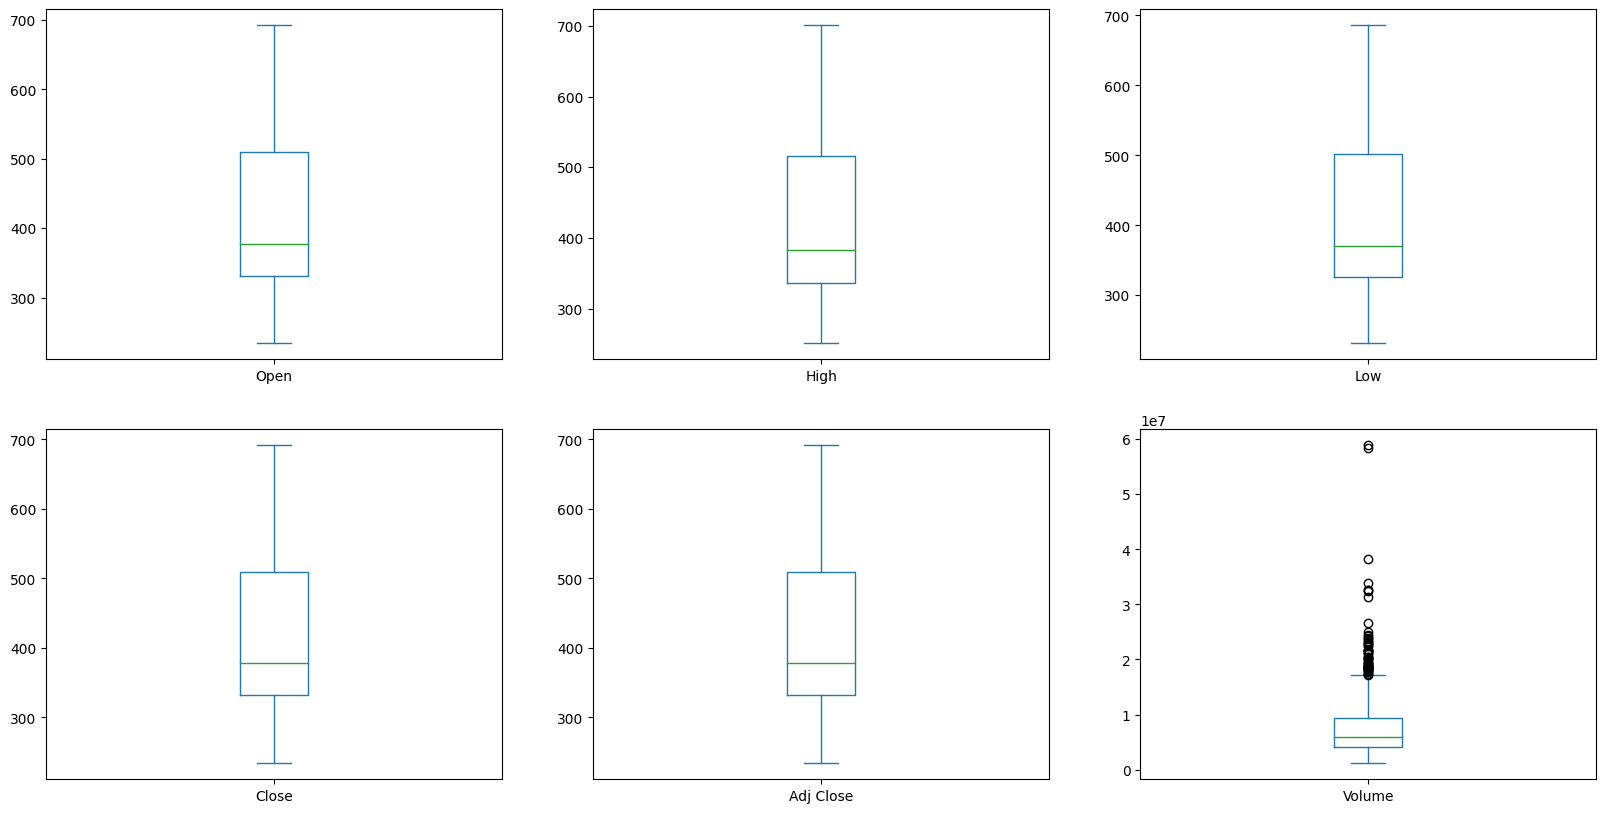

In [6]:
# Create boxplot to check for outliers for each column
fig , ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 10))

# Plots
df["Open"].plot(kind = "box", ax = ax1)
df["High"].plot(kind = "box", ax = ax2)
df["Low"].plot(kind = "box", ax = ax3)
df["Close"].plot(kind = "box", ax = ax4)
df["Adj Close"].plot(kind = "box", ax = ax5)
df["Volume"].plot(kind = "box", ax = ax6)

plt.show()


### Covert Date Column Type

In [7]:
## Convert dtype from object to datetime
df["Date"] = pd.to_datetime(df["Date"])
df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5 non-null      datetime64[ns]
 1   Open       5 non-null      float64       
 2   High       5 non-null      float64       
 3   Low        5 non-null      float64       
 4   Close      5 non-null      float64       
 5   Adj Close  5 non-null      float64       
 6   Volume     5 non-null      int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 408.0 bytes


In [8]:
## Set to index
df.set_index("Date", inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


### Data Statistics Overview


In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


## Exploratory Data Analysis

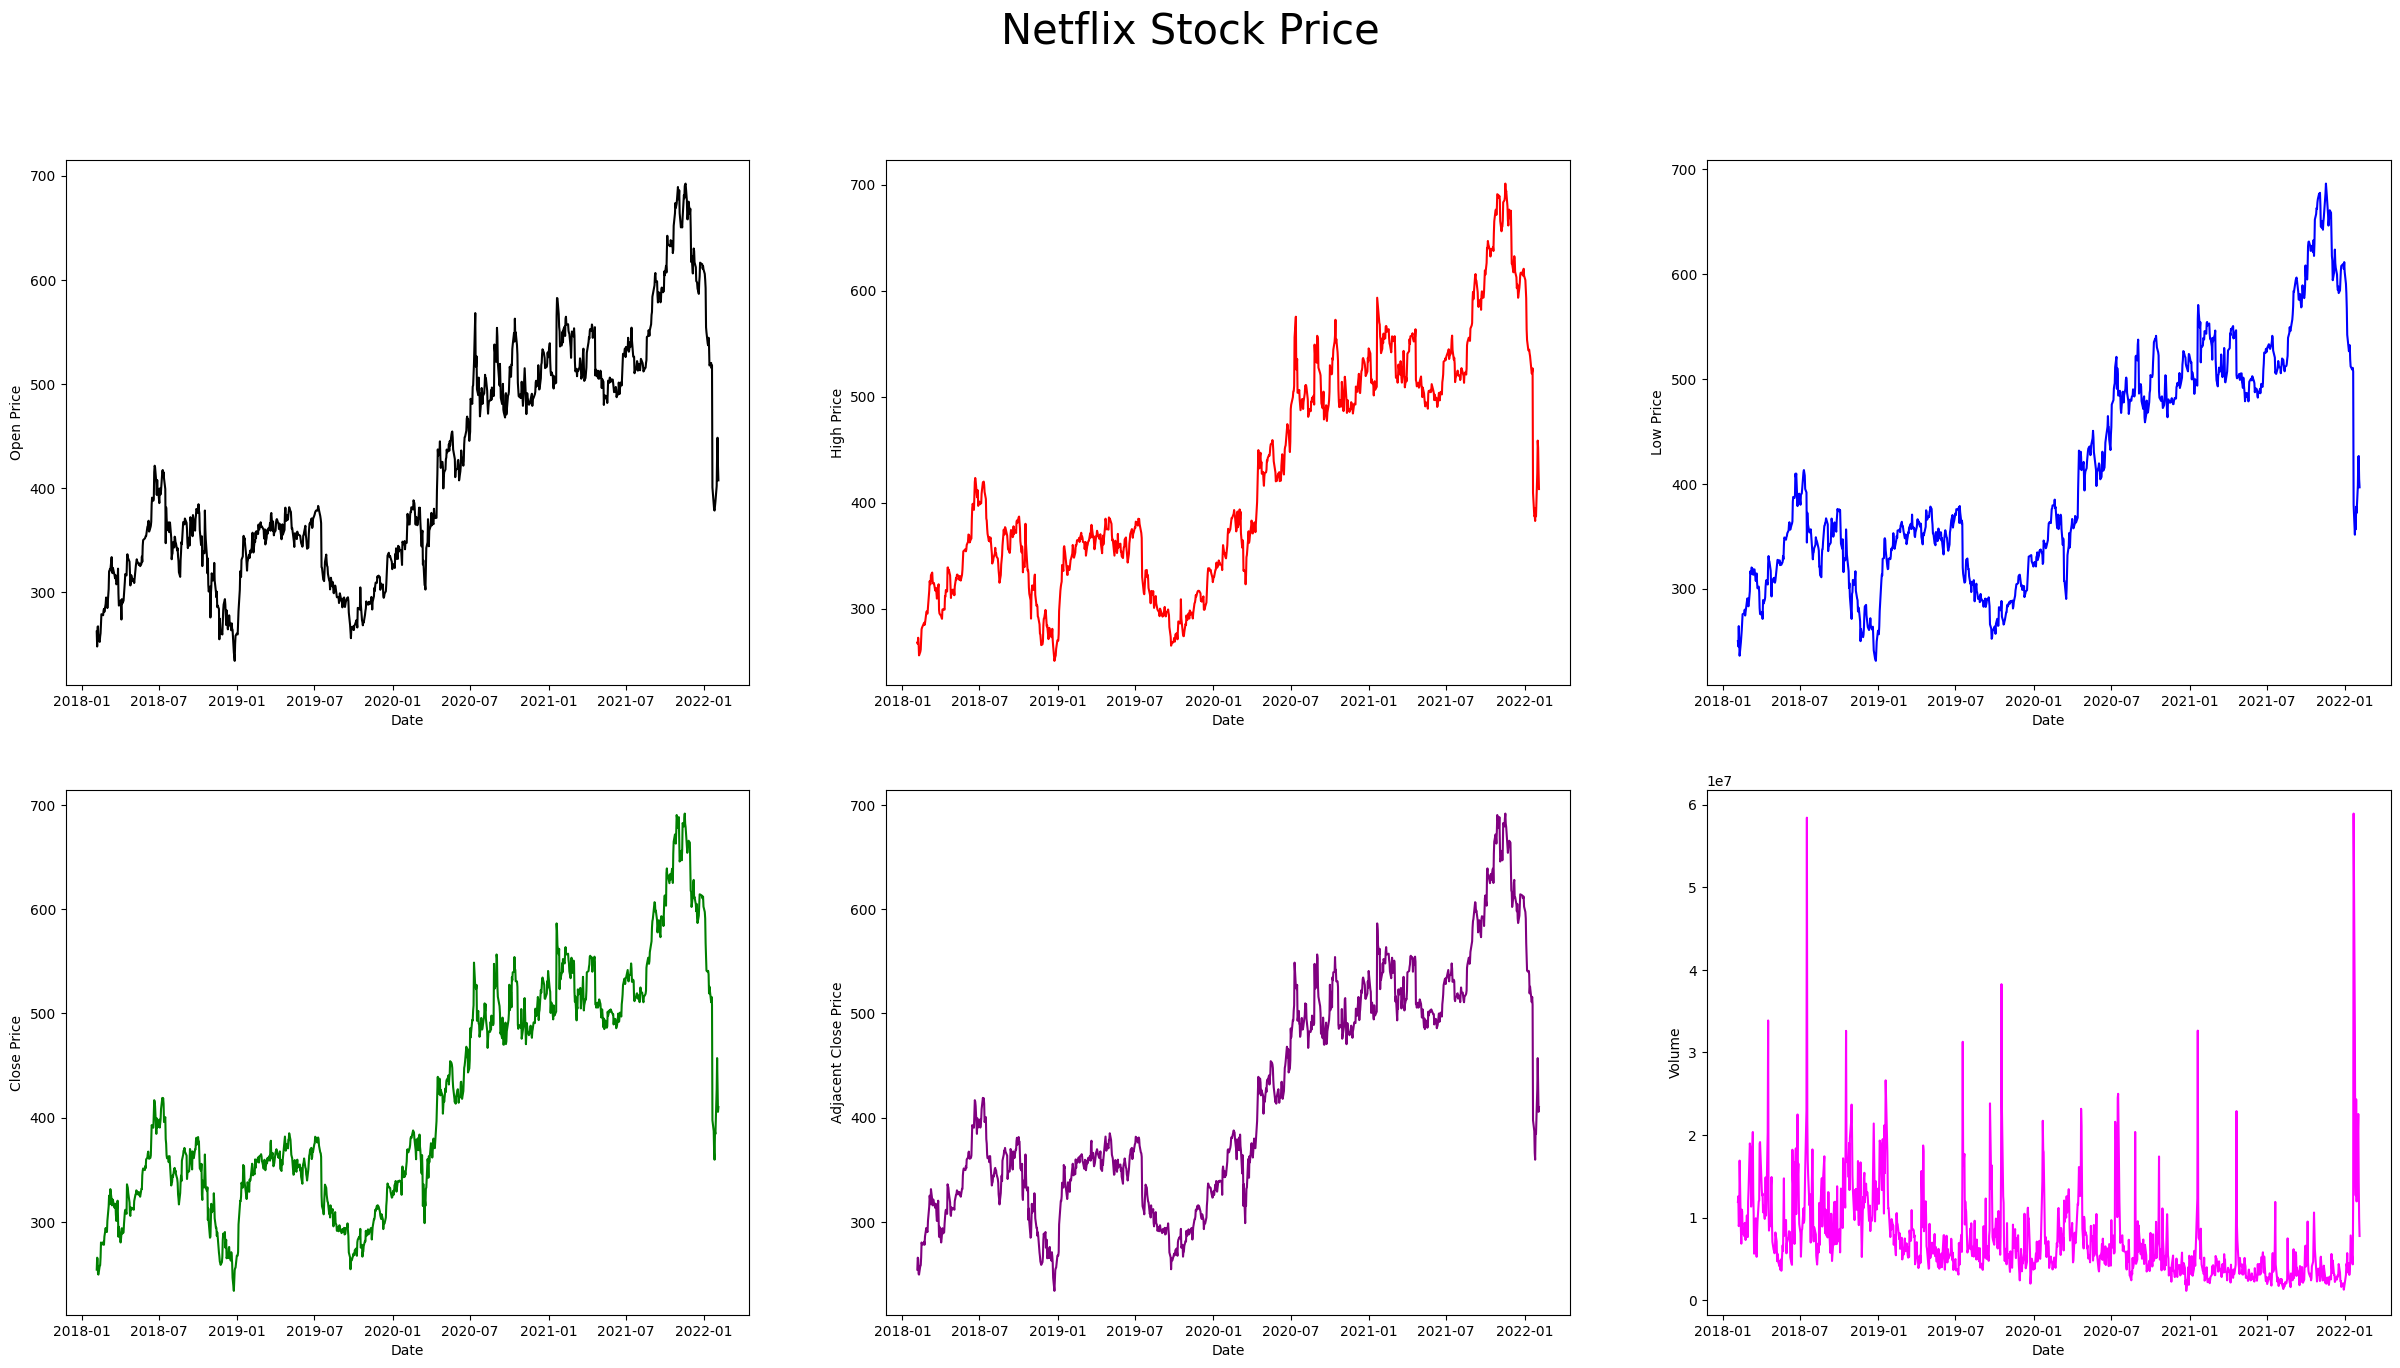

In [10]:
## Graph of all Open, High, Low, Close, Adj Close, and Volume by Date
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (30, 15))
fig.suptitle("Netflix Stock Price", fontsize = 30)

# Open
ax1.plot(df.index, df["Open"], color = "black")
ax1.set_xlabel("Date")
ax1.set_ylabel("Open Price")

# High
ax2.plot(df.index, df["High"], color = "red")
ax2.set_xlabel("Date")
ax2.set_ylabel("High Price")

# Low
ax3.plot(df.index, df["Low"], color = "blue")
ax3.set_xlabel("Date")
ax3.set_ylabel("Low Price")

# Close
ax4.plot(df.index, df["Close"], color = "green")
ax4.set_xlabel("Date")
ax4.set_ylabel("Close Price")

# Adj Close
ax5.plot(df.index, df["Adj Close"], color = "purple")
ax5.set_xlabel("Date")
ax5.set_ylabel("Adjacent Close Price")

# Volume
ax6.plot(df.index, df["Volume"], color = "magenta")
ax6.set_xlabel("Date")
ax6.set_ylabel("Volume")

plt.show()


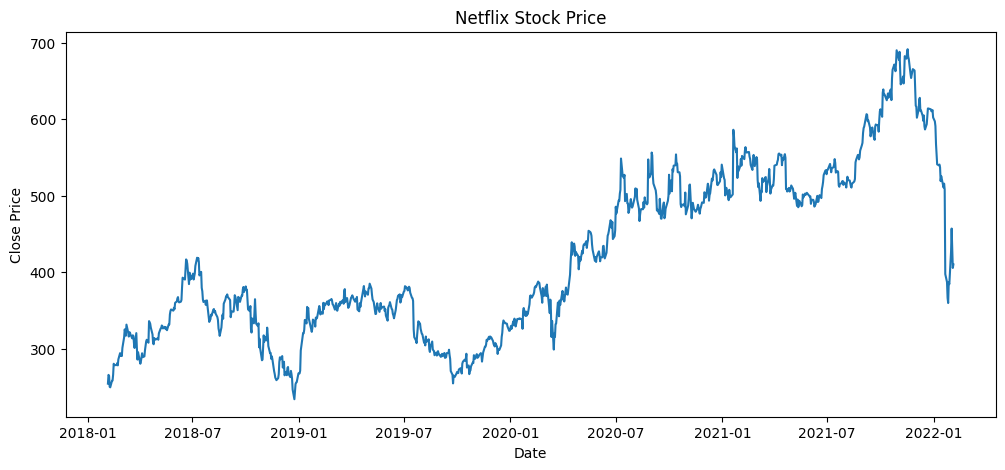

In [11]:
## Graph of all close price from the start to end
plt.figure(figsize = (12, 5))
plt.plot(df.index, df.loc[:, "Close"])
plt.title("Netflix Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

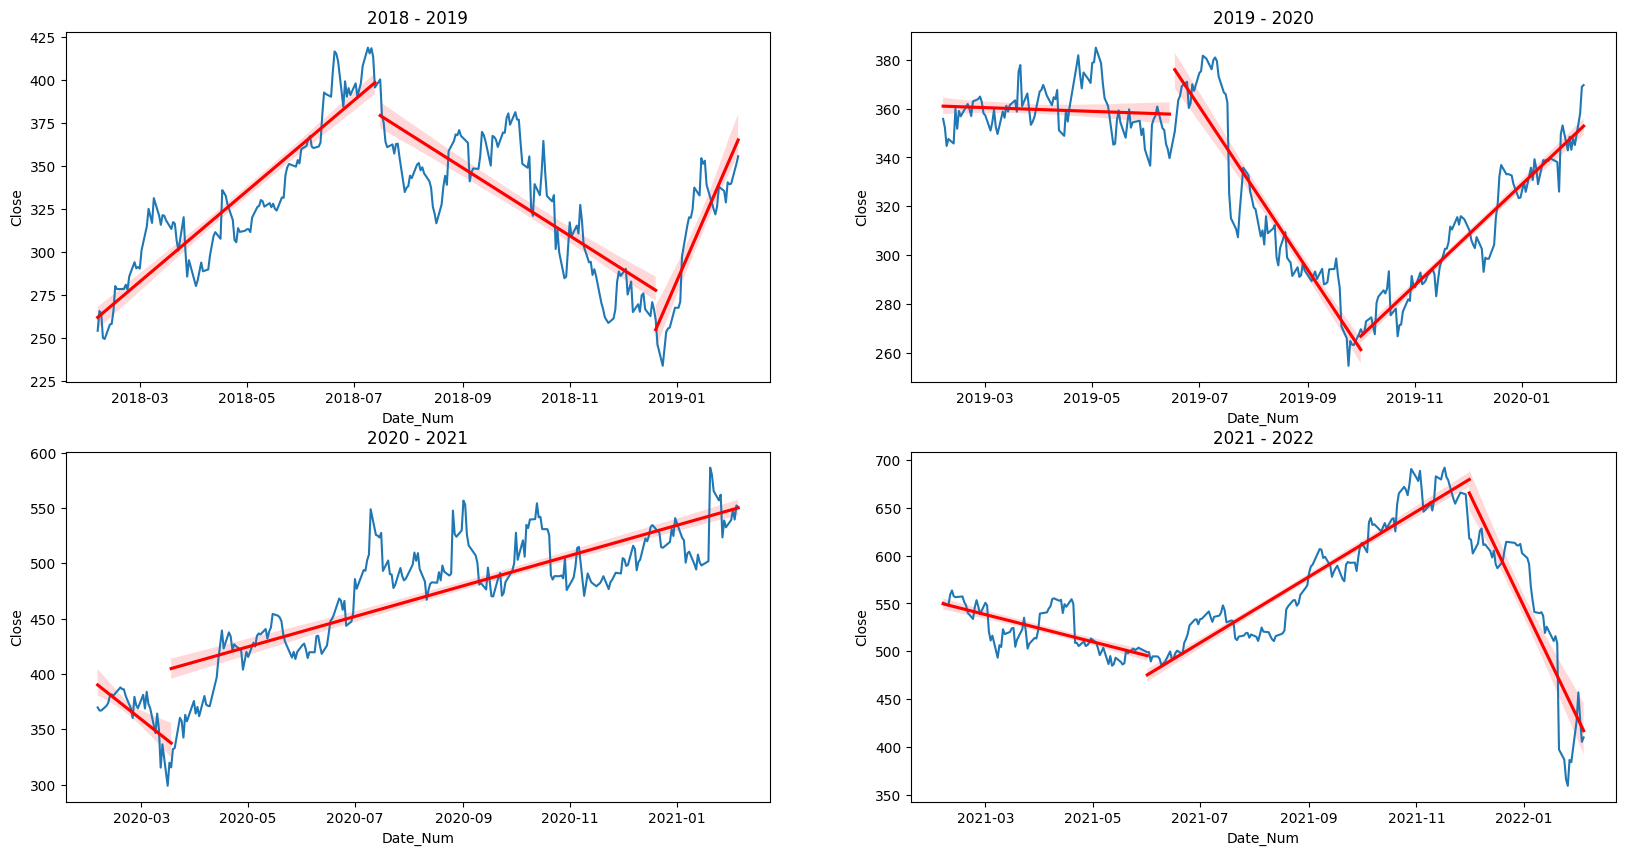

In [12]:
## Time series graph of each year interval
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

df["Date_Num"] = mdates.date2num(df.index)
# 2018 - 2019
ax[0, 0].plot(df.loc["2018-02-05" : "2019-02-05"].index, df.loc["2018-02-05" : "2019-02-05", "Close"])
sns.regplot(x = df.loc["2018-02-05" : "2018-07-15", "Date_Num"], y = df.loc["2018-02-05" : "2018-07-15", "Close"], ax = ax[0, 0], scatter = False, color = "r")
sns.regplot(x = df.loc["2018-07-15" : "2018-12-20", "Date_Num"], y = df.loc["2018-07-15" : "2018-12-20", "Close"], ax = ax[0, 0], scatter = False, color = "r")
sns.regplot(x = df.loc["2018-12-20" : "2019-02-05", "Date_Num"], y = df.loc["2018-12-20" : "2019-02-05", "Close"], ax = ax[0, 0], scatter = False, color = "r")
ax[0, 0].set_title("2018 - 2019")

# 2019 - 2020
ax[0, 1].plot(df.loc["2019-02-05" : "2020-02-05"].index, df.loc["2019-02-05" : "2020-02-05", "Close"])
sns.regplot(x = df.loc["2019-02-05" : "2019-06-15", "Date_Num"], y = df.loc["2019-02-05" : "2019-06-15", "Close"], ax = ax[0, 1], scatter = False, color = "r")
sns.regplot(x = df.loc["2019-06-15" : "2019-10-01", "Date_Num"], y = df.loc["2019-06-15" : "2019-10-01", "Close"], ax = ax[0, 1], scatter = False, color = "r")
sns.regplot(x = df.loc["2019-10-01" : "2020-02-05", "Date_Num"], y = df.loc["2019-10-01" : "2020-02-05", "Close"], ax = ax[0, 1], scatter = False, color = "r")
ax[0, 1].set_title("2019 - 2020")

# 2020 - 2021
ax[1, 0].plot(df.loc["2020-02-05" : "2021-02-05"].index, df.loc["2020-02-05" : "2021-02-05", "Close"])
sns.regplot(x = df.loc["2020-02-05" : "2020-03-18", "Date_Num"], y = df.loc["2020-02-05" : "2020-03-18", "Close"], ax = ax[1, 0], scatter = False, color= "r")
sns.regplot(x = df.loc["2020-03-18" : "2021-02-05", "Date_Num"], y = df.loc["2020-03-18" : "2021-02-05", "Close"], ax = ax[1, 0], scatter = False, color= "r")
ax[1, 0].set_title("2020 - 2021")

# 2021 - 2022
ax[1, 1].plot(df.loc["2021-02-05" : "2022-02-04"].index, df.loc["2021-02-05" : "2022-02-04", "Close"])
sns.regplot(x = df.loc["2021-02-05" : "2021-06-01", "Date_Num"], y = df.loc["2021-02-05" : "2021-06-01", "Close"], ax = ax[1, 1], scatter = False, color= "r")
sns.regplot(x = df.loc["2021-06-01" : "2021-12-01", "Date_Num"], y = df.loc["2021-06-01" : "2021-12-01", "Close"], ax = ax[1, 1], scatter = False, color= "r")
sns.regplot(x = df.loc["2021-12-01" : "2022-02-04", "Date_Num"], y = df.loc["2021-12-01" : "2022-02-04", "Close"], ax = ax[1, 1], scatter = False, color= "r")
ax[1, 1].set_title("2021 - 2022")

plt.show()

General pattern from periodicity of the graphs:
* 2018 - 2019 : Significant rise -> Drop around mid-2018 -> Recovery towards early 2019
* 2019 - 2020 : Stable period -> Decline around mid-late 2019 -> Recovery towards start of 2020
* 2020 - 2021 : Sharp Drop until Mid March 2020 -> Steady increase with fluctuations (General Upward Trend)
* 2021- 2022 : Stable (Slightly Decreasing) period -> Rise starting from mid 2021 and reaches peak at late 2021 -> Sharp Decline towards early 2022

Prediction:
* 2022 - Onwards : Could be predicted that it will have a significant recovery and rise again based on the trend as the stock trendline follows a "M" curved periodic trend of Up -> Down -> Stable / Up -> Down

## Modeling


### Train Data and Test Data
* Time Series:
    * Valid Data and Test Data needs to be more recent than Train Data as the model uses the data in the past to forecast

In [13]:
# Train Data : Test Data => 60 : 40
## Train Data 60% , 20% Validation Data , 20% Test Data
length_train = int(0.6 * len(df))   ## Train Data Size
length_val = int(0.2 * len(df))     ## Validation Data Size
length_test = int(0.2 * len(df))    ## Test Data Size

print(f"Size of each Data Sets: \nTrain: {length_train}\nValidation: {length_val}\nTest: {length_test}")

Size of each Data Sets: 
Train: 605
Validation: 201
Test: 201


### Data Scaling
* The units and number figures in the Volume column are way larger than other colums as there are numerously many trades for the stock => Need to apply scaling as a whole before training

In [14]:
scaler = MinMaxScaler()
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]])

### Create Time Series Sequences

In [67]:
# Set Parameters
sequence_length = 3
batch_size = 32

# Prepare sequences and targets
x = df["Close"].values
y = df["Close"].values

# Create Datasets
train_dataset = timeseries_dataset_from_array(
    data = x[:length_train + sequence_length - 1],
    targets = y[sequence_length : length_train + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

validation_dataset = timeseries_dataset_from_array(
    data = x[length_train : length_train + length_val + sequence_length - 1],
    targets = y[length_train + sequence_length : length_train + length_val + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

test_dataset = timeseries_dataset_from_array(
    data = x[length_train + length_val : length_train + length_val + length_test + sequence_length - 1],
    targets = y[length_train + length_val + sequence_length : length_train + length_val + length_test + sequence_length],
    sequence_length = sequence_length,
    sampling_rate = 1,
    batch_size = batch_size
)

In [68]:
for samples, targets in train_dataset:
    print("Input shape:", samples.shape)
    print("Target shape:", targets.shape)
    break

Input shape: (32, 3)
Target shape: (32,)


### Create LSTM Layer model

In [70]:
# Generate Model

model = Sequential([
    LSTM(64, input_shape = (sequence_length, 1)),
    Dense(32, activation = "relu"),
    Dense(16, activation = "relu"),
    Dense(1, activation = "linear")
])

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = "mse",
    metrics = ["mae"]
)

history = model.fit(train_dataset,
                    epochs = 100,
                    validation_data = validation_dataset,
                    callbacks = [ModelCheckpoint("bese_dese_model.keras", save_best_only = True)])


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0311 - mae: 0.1564 - val_loss: 0.0945 - val_mae: 0.3035
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - mae: 0.0534 - val_loss: 0.0461 - val_mae: 0.2098
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0052 - mae: 0.0592 - val_loss: 0.0331 - val_mae: 0.1768
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0050 - mae: 0.0575 - val_loss: 0.0249 - val_mae: 0.1521
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0044 - mae: 0.0536 - val_loss: 0.0169 - val_mae: 0.1237
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - mae: 0.0498 - val_loss: 0.0110 - val_mae: 0.0978
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mae: 0.0452 - val_loss: 0.0065 - val_mae: 0.0718
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - mae: 0.0401 - val_loss: 0.0038 - val_mae: 0.0520
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

### Evaluation

In [90]:
# Extract X_test and y_test from dataset
X_test = []
y_test = []

for samples, targets in test_dataset:
  X_test.append(samples.numpy())
  y_test.append(targets.numpy())

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - mae: 0.0462     
MSE: 0.005349950399249792
MAE: 0.05986834689974785


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


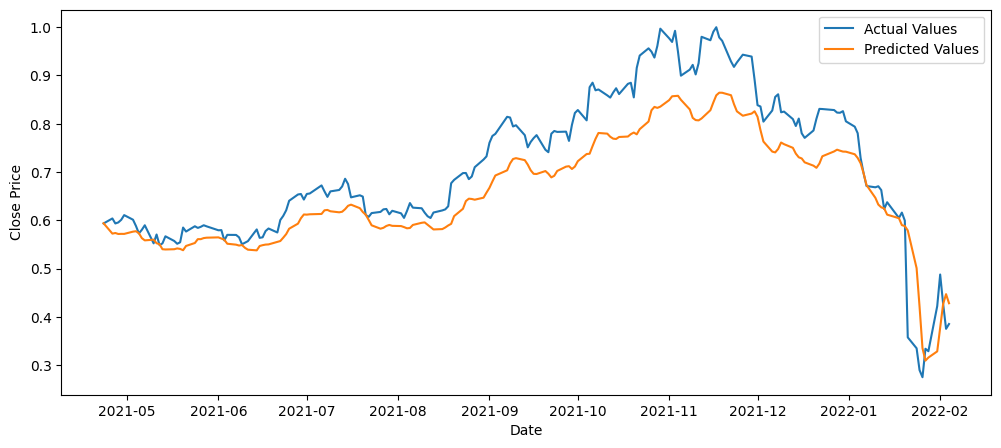

In [87]:
## Predictions
predict_test = model.predict(X_test)
test_dates = df.index[length_train + length_val + sequence_length:length_train + length_val + length_test + sequence_length]

# Plot predictions against actual values for Closed prices
plt.figure(figsize = (12, 5))
plt.plot(test_dates, y_test, label = "Actual Values")
plt.plot(test_dates, predict_test, label = "Predicted Values")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [91]:
evaluation = model.evaluate(test_dataset)
print(f"MSE: {evaluation[0]}\nMAE: {evaluation[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - mae: 0.0462
MSE: 0.005349950399249792
MAE: 0.05986834689974785
